# Basic Bioinformatics
## Sequence, Alignment, and Phylogeny
Here we will use the simple IL6 dataset to show basic skbio functionality.

First we'll handle all the necessary imports.

In [1]:
from collections import defaultdict
import functools

In [2]:
import numpy as np

In [3]:
from skbio.sequence import Protein, DNA, SubstitutionMatrix
from skbio.sequence.distance import kmer_distance, hamming
from skbio.alignment import TabularMSA, global_pairwise_align_protein, local_pairwise_align_ssw, PairAlignPath, AlignPath, global_pairwise_align_nucleotide
from skbio.stats.distance import DistanceMatrix
from skbio.tree import TreeNode, nj
from scipy.cluster.hierarchy import average
import skbio.io

In [4]:
import matplotlib.pyplot as plt

In [5]:
import warnings
warnings.filterwarnings('ignore')

## Reading sequences from fasta file
Here we're going to read in the coding regions of the IL6 gene from 7 different organisms. 
- Homo sapiens (human)
- Pan troglodytes (chimp)
- Macaca mulatta (monkey)
- Sus scrofa (pig)
- Mus musculus (mouse)
- Rattus norvegicus (rat)
- Gallus gallus (chicken)

The first step is to set the file path of the fasta file. Since we ultimately want a list of `DNA` sequences, we instantiate an empty list and append each sequence to that list using a for loop and `skbio.io.read`. By setting the `constructor` parameter to `DNA`, read will automatically convert each sequence into a scikit-bio `DNA` object. For protein or RNA sequences, the constructor can be set to `Protein` or `RNA`, respectively.

In [6]:
cds_fp = 'nucl.ffn'
seqs = []
for seq in skbio.io.read(cds_fp, format='fasta', constructor=DNA):
    seqs.append(seq)

## Basic sequence types

scikit-bio supports the three basic sequence types of biology: DNA, RNA, and Protein. Additionally, each type of sequence may include optional metadata and positional metadata, which are each mutable.

We now have a list of sequences. Python list indexing can be used to show us the first two sequences in our list. They are the human and mouse IL6 coding regions. Let's explore each of these a bit more to see what functionality scikit-bio offers.

In [7]:
human = seqs[0]
human

DNA
---------------------------------------------------------------------
Metadata:
    'description': ''
    'id': 'human'
Stats:
    length: 639
    has gaps: False
    has degenerates: False
    has definites: True
    GC-content: 50.23%
---------------------------------------------------------------------
0   ATGAACTCCT TCTCCACAAG CGCCTTCGGT CCAGTTGCCT TCTCCCTGGG GCTGCTCCTG
60  GTGTTGCCTG CTGCCTTCCC TGCCCCAGTA CCCCCAGGAG AAGATTCCAA AGATGTAGCC
...
540 GCACAGAACC AGTGGCTGCA GGACATGACA ACTCATCTCA TTCTGCGCAG CTTTAAGGAG
600 TTCCTGCAGT CCAGCCTGAG GGCTCTTCGG CAAATGTAG

In [8]:
mouse = seqs[1]
mouse

DNA
---------------------------------------------------------------------
Metadata:
    'description': ''
    'id': 'mouse'
Stats:
    length: 636
    has gaps: False
    has degenerates: False
    has definites: True
    GC-content: 41.35%
---------------------------------------------------------------------
0   ATGAAGTTCC TCTCTGCAAG AGACTTCCAT CCAGTTGCCT TCTTGGGACT GATGCTGGTG
60  ACAACCACGG CCTTCCCTAC TTCACAAGTC CGGAGAGGAG ACTTCACAGA GGATACCACT
...
540 CAGAAGGAGT GGCTAAGGAC CAAGACCATC CAATTCATCT TGAAATCACT TGAAGAATTT
600 CTAAAAGTCA CTTTGAGATC TACTCGGCAA ACCTAG

The primary information stored for each type of sequence object is the underlying sequence data itself, which is stored as an immutable NumPy array of 8-bit integers. This uses ASCII encoding and offers significant performance gains compared to operating on the strings of letters which compose the sequences.

In [9]:
human._bytes

array([65, 84, 71, 65, 65, 67, 84, 67, 67, 84, 84, 67, 84, 67, 67, 65, 67,
       65, 65, 71, 67, 71, 67, 67, 84, 84, 67, 71, 71, 84, 67, 67, 65, 71,
       84, 84, 71, 67, 67, 84, 84, 67, 84, 67, 67, 67, 84, 71, 71, 71, 71,
       67, 84, 71, 67, 84, 67, 67, 84, 71, 71, 84, 71, 84, 84, 71, 67, 67,
       84, 71, 67, 84, 71, 67, 67, 84, 84, 67, 67, 67, 84, 71, 67, 67, 67,
       67, 65, 71, 84, 65, 67, 67, 67, 67, 67, 65, 71, 71, 65, 71, 65, 65,
       71, 65, 84, 84, 67, 67, 65, 65, 65, 71, 65, 84, 71, 84, 65, 71, 67,
       67, 71, 67, 67, 67, 67, 65, 67, 65, 67, 65, 71, 65, 67, 65, 71, 67,
       67, 65, 67, 84, 67, 65, 67, 67, 84, 67, 84, 84, 67, 65, 71, 65, 65,
       67, 71, 65, 65, 84, 84, 71, 65, 67, 65, 65, 65, 67, 65, 65, 65, 84,
       84, 67, 71, 71, 84, 65, 67, 65, 84, 67, 67, 84, 67, 71, 65, 67, 71,
       71, 67, 65, 84, 67, 84, 67, 65, 71, 67, 67, 67, 84, 71, 65, 71, 65,
       65, 65, 71, 71, 65, 71, 65, 67, 65, 84, 71, 84, 65, 65, 67, 65, 65,
       71, 65, 71, 84, 65

Common operations are defined as methods, for example computing the reverse complement of a DNA sequence, or searching for N-glycosylation motifs in protein sequences. Class attributes provide valid character sets, complement maps for different sequence types, and degenerate character definitions. <br>
The positional metadata of a reverse complement will be reversed from the original sequence.

In [10]:
human.reverse_complement()

DNA
---------------------------------------------------------------------
Metadata:
    'description': ''
    'id': 'human'
Stats:
    length: 639
    has gaps: False
    has degenerates: False
    has definites: True
    GC-content: 50.23%
---------------------------------------------------------------------
0   CTACATTTGC CGAAGAGCCC TCAGGCTGGA CTGCAGGAAC TCCTTAAAGC TGCGCAGAAT
60  GAGATGAGTT GTCATGTCCT GCAGCCACTG GTTCTGTGCC TGCAGCTTCG TCAGCAGGCT
...
540 TCCTGGGGGT ACTGGGGCAG GGAAGGCAGC AGGCAACACC AGGAGCAGCC CCAGGGAGAA
600 GGCAACTGGA CCGAAGGCGC TTGTGGAGAA GGAGTTCAT

We can also transcribe, and even translate sequences with built in methods of the sequence objects.

In [11]:
human.transcribe()

RNA
---------------------------------------------------------------------
Metadata:
    'description': ''
    'id': 'human'
Stats:
    length: 639
    has gaps: False
    has degenerates: False
    has definites: True
    GC-content: 50.23%
---------------------------------------------------------------------
0   AUGAACUCCU UCUCCACAAG CGCCUUCGGU CCAGUUGCCU UCUCCCUGGG GCUGCUCCUG
60  GUGUUGCCUG CUGCCUUCCC UGCCCCAGUA CCCCCAGGAG AAGAUUCCAA AGAUGUAGCC
...
540 GCACAGAACC AGUGGCUGCA GGACAUGACA ACUCAUCUCA UUCUGCGCAG CUUUAAGGAG
600 UUCCUGCAGU CCAGCCUGAG GGCUCUUCGG CAAAUGUAG

In [12]:
human.translate()

Protein
---------------------------------------------------------------------
Metadata:
    'description': ''
    'id': 'human'
Stats:
    length: 213
    has gaps: False
    has degenerates: False
    has definites: True
    has stops: True
---------------------------------------------------------------------
0   MNSFSTSAFG PVAFSLGLLL VLPAAFPAPV PPGEDSKDVA APHRQPLTSS ERIDKQIRYI
60  LDGISALRKE TCNKSNMCES SKEALAENNL NLPKMAEKDG CFQSGFNEET CLVKIITGLL
120 EFEVYLEYLQ NRFESSEEQA RAVQMSTKVL IQFLQKKAKN LDAITTPDPT TNASLLTKLQ
180 AQNQWLQDMT THLILRSFKE FLQSSLRALR QM*

## Pairwise Alignment
scikit-bio also provides methods for sequence alignment. We'll start by showing the functionality of local pairwise alignment using the Striped Smith Waterman algorithm. The output of the function provides a `TabularMSA` object, the alignment score, and the start and end positions for the two sequences in the alignment. 

In [13]:
human_mouse_alignment, human_mouse_score, human_mouse_start_end_pos = local_pairwise_align_ssw(human, mouse)

/home/maton/qlab/skbio/github/scikit-bio/skbio/util/_warning.py:56: DeprecationWarning: local_pairwise_align_ssw is deprecated as of 0.5.8. It will be removed in favor of more general purpose and performant aligners. Additional details at https://github.com/scikit-bio/scikit-bio/issues/1814.
  warn(


The `TabularMSA` object is a scikit-bio data structure which is meant for intuitive manipulation and visualization of pairwise or multiple sequence alignments. For a more memory and compute efficient data structure, scikit-bio now has `AlignPath`, which we will explore below.

In [14]:
human_mouse_alignment

TabularMSA[DNA]
-----------------------------------------------------------------------
Stats:
    sequence count: 2
    position count: 588
-----------------------------------------------------------------------
ATGAACTCCTTCTCCACAAGCGCCTTCGGTCCA ... AAGCTGCAGGCACAGAACCAGTGGCTGCAGGAC
ATGAAGTTCCTCTCTGCAAGAGACTTCCATCCA ... AAGCTGGAGTCACAGAAGGAGTGGCT-AAGGAC

In [15]:
human_mouse_score

138

In [16]:
human_mouse_start_end_pos

[(0, 563), (0, 559)]

Conversion from `TabularMSA` objects to `PairAlignPath` objects is simple. The `PairAlignPath` represents the entire alignment using two arrays, `lengths` and `states`. The `lengths` array represents the segment length for each segment with consistent gap status. The sum of the `lengths` array is equal to the number of the positions in the alignment, in our case 588. If you are familiar with CIGAR strings for pairwise alignment, each value of the `lengths` array corresponds to the integer values in the corresponding CIGAR string.

In [17]:
human_mouse_path = PairAlignPath.from_tabular(human_mouse_alignment)

In [18]:
human_mouse_path.lengths

array([43,  3, 48,  2,  5,  2, 14,  1,  2,  1,  4,  1,  4,  1,  5,  1,  8,
        1, 12,  2,  4,  2,  3,  2,  2,  2,  6,  3,  4,  1,  1,  1,  4,  2,
       32,  3,  9,  1,  9,  2, 45,  1,  5,  1, 78,  2,  2,  2, 22,  1,  9,
        1,  9,  2,  2,  1, 18,  1,  3,  1,  4,  1,  5,  1, 77,  1,  5,  1,
       27,  1,  6])

In [19]:
human_mouse_path.lengths.sum()

np.int64(588)

In [20]:
human_mouse_path.to_cigar()

'43M3D48M2D5M2I14M1I2M1D4M1I4M1D5M1I8M1D12M2I4M2D3M2I2M2I6M3D4M1D1M1D4M2D32M3I9M1D9M2D45M1D5M1I78M2D2M2I22M1D9M1I9M2I2M1I18M1D3M1I4M1I5M1D77M1I5M1D27M1D6M'

The `states` array represents the gap status of each individual segment in the alignment. For a pairwise alignment `0` means (mis)match, `1` means insertion, and `2` means deletion. If greater resolution is desired between match and mismatch (`=` and `X` vs `M` in CIGAR strings), you may pass the sequences to `to_cigar`.

In [21]:
human_mouse_path.states

array([[0, 2, 0, 2, 0, 1, 0, 1, 0, 2, 0, 1, 0, 2, 0, 1, 0, 2, 0, 1, 0, 2,
        0, 1, 0, 1, 0, 2, 0, 2, 0, 2, 0, 2, 0, 1, 0, 2, 0, 2, 0, 2, 0, 1,
        0, 2, 0, 1, 0, 2, 0, 1, 0, 1, 0, 1, 0, 2, 0, 1, 0, 1, 0, 2, 0, 1,
        0, 2, 0, 2, 0]], dtype=uint8)

In [22]:
human_mouse_path.to_cigar(seqs=[human_mouse_alignment[0], human_mouse_alignment[1]])

'5=1X1=1X1=1X4=2X4=1X1=1X4=2X14=3D4X1=3X2=2X2=1X2=1X2=1X1=2X1=2X1=3X1=4X1=2X1=3X2=3X2D5X2I2X2=4X1=5X1I2X1D4X1I2X1=1X1D1=2X1=1X1I1X1=1X1=4X1D5X1=3X1=2X2I4X2D2X1=2I2X2I2X1=3X3D4X1D1=1D2X1=1X2D6X2=11X1=2X1=1X2=2X2=1X1=3I1X1=4X1=2X1D7X1=1X2D2=20X1=1X1=5X3=7X1=4X1D1=3X1=1I2X1=6X1=4X2=1X2=15X1=4X1=7X1=2X1=8X1=6X1=1X1=1X1=2X1=1X1=2X2D1X1=2I7X1=1X3=10X1D9X1I1X1=1X1=2X1=2X2I2X1I4X1=5X1=1X1=2X1=2X1D3X1I4X1I2X2=1X1D2=1X1=4X2=8X1=4X2=2X1=8X1=4X2=2X1=1X1=5X2=10X1=1X2=4X2=1X1=1I3X2=1D1X1=1X1=11X2=7X2=1X1D6X'

## Multiple Sequence Alignment
It is also possible to use scikit-bio to perform a multiple sequence alignment. Here, we will first translate the sequences into protein, and align the protein sequences from our seven organisms. We also create a dictionary of the sequences where each key is the name of the organism, and each value is the `Protein` sequence of that organism. This step is necessary for the progressive alignment function we've written. As you see below, translation of all the sequences is possible in a single line of code using list comprehension.

In [23]:
prot_seqs = [seq.translate() for seq in seqs]

In [24]:
names = ('human', 'mouse', 'rat', 'chicken', 'pig', 'chimp', 'monkey')

In [25]:
prot_seqs_dict = {name: sequence for name, sequence in zip(names, prot_seqs)}

In [26]:
prot_seqs_dict['pig']

Protein
---------------------------------------------------------------------
Metadata:
    'description': ''
    'id': 'pig'
Stats:
    length: 213
    has gaps: False
    has degenerates: False
    has definites: True
    has stops: True
---------------------------------------------------------------------
0   MNSLSTSAFS PVAFSLGLLL VMATAFPTPG RLEEDAKGDA TSDKMLFTSP DKTEELIKYI
60  LGKISAMRKE MCEKYEKCEN SKEVLAENNL NLPKMAEKDG CFQSGFNQET CLMRITTGLV
120 EFQIYLDYLQ KEYESNKGNV EAVQISTKAL IQTLRQKGKN PDKATTPNPT TNAGLLDKLQ
180 SQNEWMKNTK IILILRSLED FLQFSLRAIR IM*

Now with all of our sequences translated we can build a distance matrix. To do this, we use scikit-bio's `DistanceMatrix.from_iterable()` method, which automatically creates a distance matrix for all pairs of items in a Python iterable, in this case the list of sequences. The `DistanceMatrix` object will automatically create a heatmap by simply calling the object. As our distance metric, we will use the hamming distance.

In [27]:
# matrix = SubstitutionMatrix.by_name('blosum62')

In [28]:
def align_dist(seq1, seq2):
    aln = local_pairwise_align_ssw(seq1, seq2)[0]
    return hamming(aln[0], aln[1])

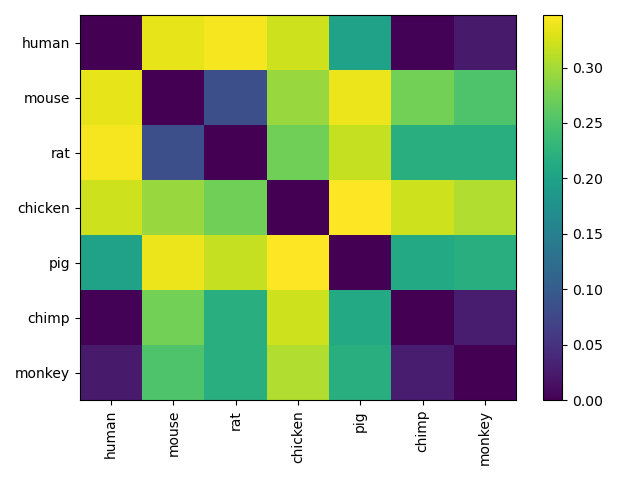

In [29]:
dm = DistanceMatrix.from_iterable(seqs, align_dist, key='id', validate=False)
dm

Once we've created our distance matrix, we generate a tree based on this matrix. This tree will serve as the guide tree for the progressive alignment algorithm below.

In [30]:
tree = nj(dm).root_at_midpoint()
print(tree.ascii_art())

                    /-chicken
          /--------|
         |         |          /-rat
         |          \--------|
-root----|                    \-mouse
         |
         |          /-pig
         |         |
          \--------|                    /-chimp
                   |          /--------|
                    \--------|          \-human
                             |
                              \-monkey


In [31]:
guide_lm = average(dm.condensed_form())

In [32]:
guide_tree = TreeNode.from_linkage_matrix(guide_lm, dm.ids)

Here we define our progressive alignment function. 

In [33]:
def progressive_msa(query_seqs, guide_tree, pairwise_aligner=global_pairwise_align_protein):
    c1, c2 = guide_tree.children
    if c1.is_tip():
        c1_aln = query_seqs[c1.name]
    else:
        c1_aln = progressive_msa(query_seqs, c1, pairwise_aligner)

    if c2.is_tip():
        c2_aln = query_seqs[c2.name]
    else:
        c2_aln = progressive_msa(query_seqs, c2, pairwise_aligner)

    return pairwise_aligner(c1_aln, c2_aln)[0]

Here we perform progressive alignment. By default, the alignment programs in scikit-bio will return `TabularMSA` objects. As mentioned previously, these are intuitive data structures and have several built in methods which are useful. Here we can see what the consensus sequence among the alignment is by calling the `consensus` method.

In [34]:
msa_new = progressive_msa(prot_seqs_dict, guide_tree)

In [35]:
msa_new

TabularMSA[Protein]
-----------------------------------------------------------------------
Stats:
    sequence count: 7
    position count: 286
-----------------------------------------------------------------------
--------------------------------- ... TKIILILRSLEDFLQFSLRAIRIM*--------
MNSVSTSKCRKSLALERPAAVEPCVREGCVAQG ... --CHF----QKRRLHVNKKV*------------
...
--------------------------------- ... KTIQFILKSLEEFLKVTLRSTRQT*--------
--------------------------------- ... KTIQLILKALEEFLKVTMRSTRQT*--------

In [36]:
msa_new.consensus()

Protein
---------------------------------------------------------------------
Stats:
    length: 286
    has gaps: True
    has degenerates: False
    has definites: True
    has stops: True
---------------------------------------------------------------------
0   ---------- ---------- ---------- ---------- ---------- --MNSLFLST
60  GAFGPVAFSL GLLL------ VLAAAFPA-P VRPGEDSKDD AAPHRQPLTS SERIDKLIRY
120 IL-DGISALR KETCNKSNMC ENSKEALAEN NLNLPKMAEK DGCFQSGFNE ETCLVKIITG
180 LLEFEVYLEY LQNRFESSE- EQARAVQMST KVLIQFLQQK V--KNFDKIV LPDPTLNASL
240 LDKLESQNEW LQTKTIHLIL RSLEEFLQVT LRA*RQM*-- ------

We can also convert the `TabularMSA` object into an `AlignPath` object like we did earlier. `AlignPath` objects are exactly like `PairAlignPath` objects except that they don't have a few methods which are specific to pairwise alignments. The underlying data structure is the same, and can be quite useful.

In [37]:
msa_path = AlignPath.from_tabular(msa_new)

In [38]:
msa_path.lengths

array([36, 16,  2,  2,  2, 10,  1,  5,  6,  8,  1,  7,  1, 15,  1,  3,  6,
        1,  1,  1, 70,  1,  3,  1, 20,  1,  1,  1, 18,  5,  6,  3,  3,  4,
       12,  4,  8])

In [39]:
msa_path.states

array([[117, 101,  96,   0,   5,   0, 112,   0, 111,   0,  15,   0,  96,
          0, 112,  16,   0,  15,   0,  96,   0,  16,   0,  15,   0,   5,
        117, 112,   0,  10,   0,  10,   0,  10,   0,  10, 111]],
      dtype=uint8)

## MSA Exploration
Based on this notebook
https://github.com/scikit-bio/scikit-bio-cookbook/blob/master/Alignments%20and%20phylogenetic%20reconstruction.ipynb

We can next get some information about this alignment. For example, we can easily see that there are 43 sequences in this alignment, and that it's 154 characters long. By definition, there is no variance in sequence length in a multiple sequence alignment. For this reason, it's common to think of an alignment as a matrix or table, where rows represent sequences and columns represent positions in the sequences.

In [40]:
msa_new.shape

Shape(sequence=7, position=286)

In [41]:
msa_new.index

RangeIndex(start=0, stop=7, step=1)

We can also explore some more interesting features of this alignment. For example, we can compute conservation for each position in the alignment using the inverse Shannon uncertainty metric. In this case, we're going to treat gap characters as another character in the amino acid alphabet, though the right way to handle gaps in alignments when computing conservation is debatable. To learn more about positional conservation, see `TabularMSA.conservation`.

In [42]:
positional_conservation = msa_new.conservation(metric='inverse_shannon_uncertainty', degenerate_mode='nan', gap_mode='include')

We get an array of positional conservation values (here we'll just print the first ten). A low conservation value means that there is a lot of variation in the sequences at the corresponding position in the alignment, while a high conservation value means that the corresponding position in the alignment is highly conserved. A conservation of 1.0 means that a position is perfectly conserved. A conservation of 0.0 means that every character in the alphabet is present in exactly equal frequency at that position in the alignment (this is uncommon in practice).

In [43]:
for value in positional_conservation[100:110]:
    print(value)

0.6951996000320066
0.7822008086536675
0.6320382487584343
0.5927167548329499
0.7460331337470384
0.5927167548329499
0.5927167548329499
0.6951996000320066
0.8692020172753283
0.6951996000320066


In our alignment, there are exactly 38 positions that are perfectly conserved across all sequences.

In [44]:
(positional_conservation == 1.0).sum()

np.int64(29)

Let's figure out what amino acids are at these perfectly conserved positions:

In [45]:
for pos_idx, conservation in enumerate(positional_conservation):
    if conservation == 1.0:
        aa = msa_new[0][pos_idx]
        print(f"Position {pos_idx} is perfectly conserved, containing {aa} in all sequences.")

Position 64 is perfectly conserved, containing P in all sequences.
Position 65 is perfectly conserved, containing V in all sequences.
Position 66 is perfectly conserved, containing A in all sequences.
Position 69 is perfectly conserved, containing L in all sequences.
Position 71 is perfectly conserved, containing L in all sequences.
Position 73 is perfectly conserved, containing L in all sequences.
Position 86 is perfectly conserved, containing P in all sequences.
Position 121 is perfectly conserved, containing L in all sequences.
Position 131 is perfectly conserved, containing E in all sequences.
Position 133 is perfectly conserved, containing C in all sequences.
Position 139 is perfectly conserved, containing C in all sequences.
Position 146 is perfectly conserved, containing L in all sequences.
Position 149 is perfectly conserved, containing N in all sequences.
Position 150 is perfectly conserved, containing N in all sequences.
Position 151 is perfectly conserved, containing L in al

Finally we can visualize the conservation along the full length of the alignment to get an idea of where the more and less conserved positions are found. In general, positions that are highly conserved are thought to have specific structural or functional roles in the protein, while positions that are less conserved might have less specific roles (e.g., providing a filler between two functional domains in the linear protein backbone).

Text(0.5, 1.0, 'Positional Conservation Plot')

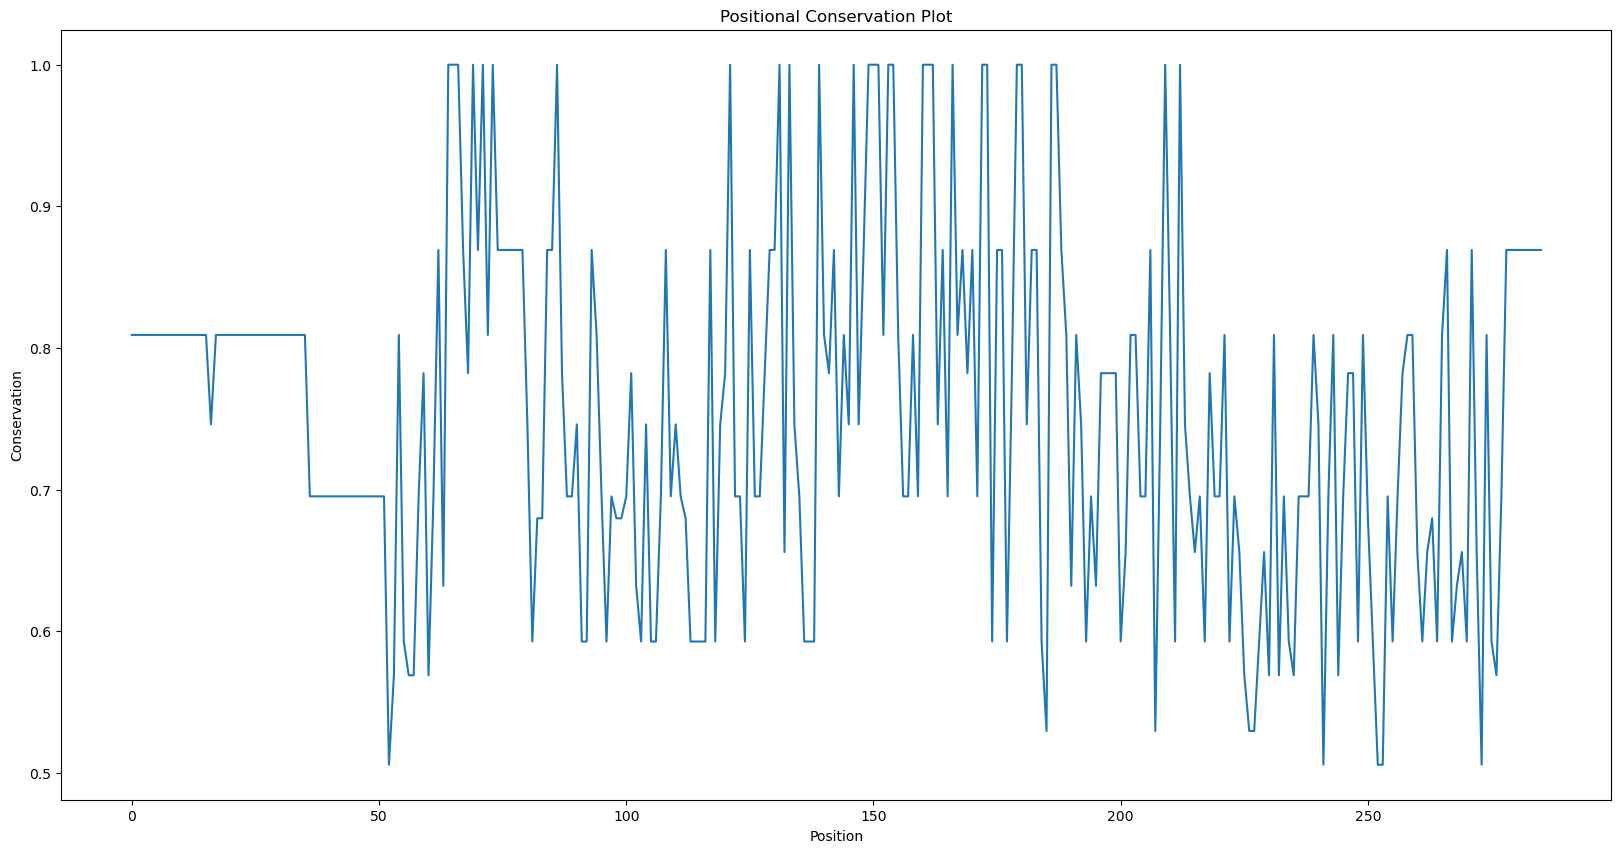

In [46]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(range(len(positional_conservation)), positional_conservation)
ax.set_xlabel('Position')
ax.set_ylabel('Conservation')
ax.set_title('Positional Conservation Plot')